In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
NUM_URLS = 37941676

In [3]:
with open('../data/google.pkl', 'rb') as f:
    results = pickle.load(f)

In [4]:
results_simple = {}
for search, result in results.items():
    pages = result['items']
    links = []
    for page in pages:
        links.append(page['link'])
    results_simple[search] = links

In [5]:
# DO THIS BEFORE HASH_TRAIN.CPP
with open('../data/train_urls.txt', 'w') as f:
    for idx, result in enumerate(results_simple.values()):
        for link in result:
            f.write(str(idx) + ' ' + link + '\n')

In [6]:
# DO THIS AFTER HASH_TRAIN.CPP
pageranks = np.zeros(NUM_URLS, dtype=float)
with open('../data/links_pagerank.txt', 'r') as f:
    for idx, pagerank in enumerate(f):
        pageranks[idx] = float(pagerank)
        
cheiranks = np.zeros(NUM_URLS, dtype=float)
with open('../data/links_cheirank.txt', 'r') as f:
    for idx, cheirank in enumerate(f):
        cheiranks[idx] = float(cheirank)
        
communities = np.zeros(NUM_URLS, dtype=int)
with open('../data/links_communities.txt', 'r') as f:
    for idx, community in enumerate(f):
        communities[idx] = community
        
community_counts = np.zeros(NUM_URLS, dtype=int)
with open('../data/links_community_counts.txt', 'r') as f:
    for idx, count in enumerate(f):
        community_counts[idx] = count

In [ ]:
data_dict = {'url': [], 'id': [], 'community': [], 'community size': [], 'pagerank': [], 'cheirank': [], 'qid': [], 'relevance': []}
counts = []
with open('../data/train_urls_processed.txt', 'r') as f:
    old_qid = None
    for line in f:
        qid, url, hash = line.split()
        if qid == old_qid:
            relevance -= 1
        else:
            relevance = 10
        old_qid = qid
        qid = int(qid)
        hash = int(hash)
        
        if hash == -1:
            continue
        
        data_dict['url'].append(url)
        data_dict['id'].append(hash)
        data_dict['community'].append(communities[hash])
        data_dict['community size'].append(community_counts[hash])
        data_dict['pagerank'].append(pageranks[hash])
        data_dict['cheirank'].append(cheiranks[hash])
        data_dict['qid'].append(qid)
        data_dict['relevance'].append(relevance)
        while (len(counts) <= qid):
            counts.append(0)
        counts[qid] += 1

''' 
# Insert a random point
for idx, count in enumerate(counts):
    for _ in range(count):
        size = len(data_dict['url'])
        while True:
            random_point = random.randint(0, size - 1)
            if data_dict['qid'][random_point] != idx:
                break
        
            data_dict['url'].append(data_dict['url'][random_point])
            data_dict['id'].append(data_dict['id'][random_point])
            data_dict['community'].append(data_dict['community'][random_point])
            data_dict['community size'].append(data_dict['community size'][random_point])
            data_dict['pagerank'].append(data_dict['pagerank'][random_point])
            data_dict['cheirank'].append(data_dict['cheirank'][random_point])
            data_dict['qid'].append(data_dict['qid'][random_point])
            data_dict['relevance'].append(0) # TODO: maybe use a smarter relevance
'''

data_df = pd.DataFrame(data_dict)
data_df.to_csv('../data/train.csv', index=False)

In [21]:
len(data_df.columns)

8

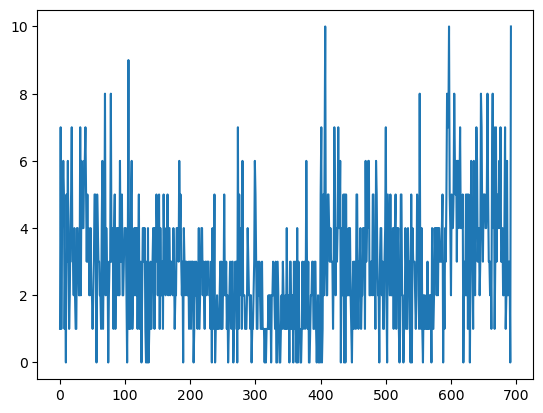

In [8]:
X = data_df.iloc[:, 1:-1]
y = data_df.iloc[:, -1]

In [17]:
X

,id,community,community size,pagerank,cheirank,qid
0,8297940,0,27793987,9.409280e-09,1.708830e-08,0
1,1562506,100,1,9.409280e-09,1.708830e-08,1
2,32492858,0,27793987,2.103470e-07,3.509090e-08,1
3,33052478,0,27793987,1.195360e-06,1.844790e-08,1
4,21631116,0,27793987,4.304920e-06,2.246690e-08,1
...,...,...,...,...,...,...
1981,34373081,0,27793987,1.283480e-06,1.712030e-08,692
1982,4881725,0,27793987,6.490370e-05,1.710690e-08,692
1983,22445707,0,27793987,9.409280e-09,2.111140e-08,692
1984,36094356,0,27793987,4.476200e-07,1.753580e-08,692


In [9]:
ranker = xgb.XGBRanker(tree_method="hist", lambdarank_num_pair_per_sample=8, objective="rank:ndcg", lambdarank_pair_method="topk")
ranker.fit(X, y)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=8, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

In [10]:
scores = ranker.predict(X)

In [11]:
y

0       2
1       9
2       7
3       6
4       5
       ..
1981    5
1982    4
1983    3
1984    2
1985    1
Name: relevance, Length: 1986, dtype: int64

In [12]:
y.to_numpy()

array([2, 9, 7, ..., 3, 2, 1], shape=(1986,))

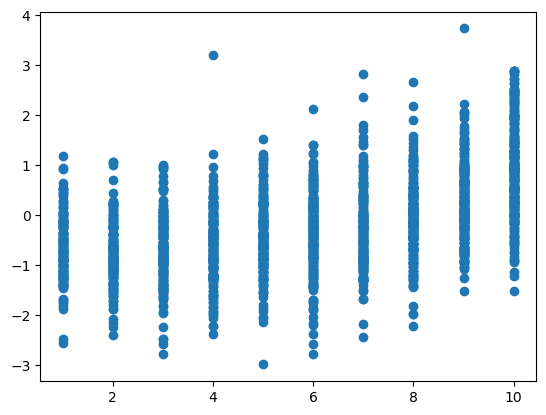

In [13]:
plt.scatter(y.to_numpy(), scores)